
## <span style="background-color:#FFD012">Import Packages</span>

In [9]:
#Import modules required
try:

    #Standard modules
    import pandas as pd
    import numpy as np
    import re
    import time
    import math
    from datetime import datetime, date
    import matplotlib.pyplot as plt
    import seaborn as sns

    #Web scraping modules
    from bs4 import BeautifulSoup
    import requests
    from selenium import webdriver
    from selenium.webdriver.chrome.service import Service as ChromeService
    from webdriver_manager.chrome import ChromeDriverManager
    from selenium.webdriver.chrome.options import Options
    
    #Currency Converter
    from currency_converter import CurrencyConverter
    from currency_converter import SINGLE_DAY_ECB_URL

    #Pygsheets Google Sheet Connection
    import pygsheets
    

except ModuleNotFoundError:
    print('Please install required libraries: Beautiful Soup, Selenium, CurrencyConverter, Chrome WebDriver, pygsheets')

# <span style="background-color:#FFD012">Function for page number calculation</span>

In [10]:
def get_page_numbers(listings_per_page, number_of_listings):
        
        """Function that calculates the number of pages per URL that has to be scraped"""
        
        #Adding +1 as range argument is exclusive
        pages_to_scrape = math.ceil(number_of_listings/listings_per_page+1)
        
        print('Scraping: ', pages_to_scrape-1, ' page(s) per model', '\n')
        return pages_to_scrape
    

# <span style="background-color:#FFD012">Function for currency conversion</span>

In [11]:
def sek_to_usd_converter(list_of_prices):
    
    """Function that converts price from SEK to USD via ECB"""
    
    prices_converted = []
    c = CurrencyConverter(SINGLE_DAY_ECB_URL)

    for i in list_of_prices:
        convert = int(c.convert(i, "SEK", "USD"))
        prices_converted.append(convert)
        list_of_prices = prices_converted
        
    return list_of_prices

# <span style="background-color:#FFD012">Ebay</span>


## <span style="background-color:#FFD700"> Ebay Active Listings</span>

In [12]:
#Dictionary of URLs to scrape (per model)
ebay_active_url_dict = {'OP-1':'https://www.ebay.com/sch/i.html?_from=R40&_sacat=0&_udlo&_udhi&LH_BIN=1&_ftrt=901&_ftrv=1&_sabdlo&_sabdhi&_samilow&_samihi&_sadis=15&_stpos&_sop=12&_dmd=1&_ipg=240&_fosrp=1&_nkw=teenage%20engineering%20op-1%20-field&_dcat=38071&rt=nc&LH_ItemCondition=3000&_trksid=p2045573.m1684', 
            'OP-Z': 'https://www.ebay.com/sch/i.html?_from=R40&_sacat=0&_udlo&_udhi&LH_BIN=1&_ftrt=901&_ftrv=1&_sabdlo&_sabdhi&_samilow&_samihi&_sadis=15&_stpos&_sop=12&_dmd=1&_ipg=240&_fosrp=1&_nkw=teenage%20engineering%20op-z&_dcat=38071&rt=nc&LH_ItemCondition=3000&_trksid=p2045573.m1684'}



def get_ebay_active_listings(insert_url):
        
    """Function that scrapes info from active eBay listings for Teenage Engineering Synthesizer models OP-1 and OP-Z"""
    
    print('Ebay Active Listings: ')

    #Containers for temporary storage
    item_name = []
    item_price = []
    item_country = []
    marketplace = 'ebay'
    model_name = []


    #Iterate over URLs included in ebay_active_url_dict
    for x in insert_url.values():
        
        
        #Retrieve HTML code
        ebay_url = x
        r= requests.get(ebay_url)
        data=r.text
        soup=BeautifulSoup(data)

        #Defining fixed number of listings per page
        listings_per_page = 240
        #Scraping actual number of listings per page
        number_of_listings = int(soup.find('span', attrs={'class':'rcnt'}).find(text=True, recursive=False))

        #Call page number function to calculate n number of pages to scrape
        pages_to_scrape = get_page_numbers(listings_per_page, number_of_listings)

        #Iterate over n number of pages per URL
        for i in range(1, pages_to_scrape):

            #Retrieve model specific HTML per URL and page no.
            ebay_url = x+str(i)
            r= requests.get(ebay_url)
            data=r.text
            soup=BeautifulSoup(data)
            
            
            #Retrieve HTML for individual listings
            listings = soup.find_all('li', attrs={'class': 'sresult lvresult clearfix li'})

            #Iterate over each individual listing to scrape desired data and append to containers
            for listing in listings:
                
                #Separate each listing by title
                for name in listing.find_all('a', attrs={'class':"vip"}):
                    
                    #Exclude None-Type Objects
                    if name.string != None:
                        
                        #Listing Title
                        name.string = str.lower(name.string).replace('\r\n\t\t','')
                        item_name.append(name.string)

                        #Listing Price
                        price = int(float(str(listing.find('span', attrs={'class':"bold"}).find(text=True, recursive=False).replace('\n\t\t\t\t\t','').replace(',', ''))))
                        item_price.append(price)
                    
                        #Listing Country
                        country = str(listing.find('ul', attrs={'class':'lvdetails left space-zero full-width'}).find(text = False, recursive = False)).replace('<li>\n\t\t\t\t\tFrom ', '').replace('</li>', '')
                        item_country.append(country)
                        
                        #Add Model Name
                        for i in name:
                            name_var = ['op1', 'op-1', 'op 1', 'op_1']
                            matchers = [s for s in name if any(xs in s for xs in name_var)]
                            [model_name.append('OP-1') if i in matchers else model_name.append('OP-Z') for i in name]  
                            
                
                            
    #Call currency converter function
    item_price = sek_to_usd_converter(item_price) 
    
    #Create df
    ebay_current_listings = pd.DataFrame({"listing":item_name, "model_name":model_name, "price_usd": item_price, 'marketplace' : marketplace, "country": item_country})
    
    return ebay_current_listings

## <span style="background-color:#FFD700">Ebay Sold Items</span>

In [13]:
#Dictionary of URLs to scrape (per model)
ebay_sold_url_dict = {'OP-1':'https://www.ebay.com/sch/i.html?_dmd=1&_osacat=0&_sop=13&LH_ItemCondition=4&_ipg=240&LH_Complete=1&_odkw=teenage+engineering+op-1+-OP-Z+-OPZ&LH_Sold=1&_sadis=15&_from=R40&_trksid=p2045573.m570.l1313&_nkw=teenage+engineering+op-1+-OP-Z+-OPZ+-field&_sacat=0', 
        'OP-Z': 'https://www.ebay.com/sch/i.html?_dmd=1&_osacat=38071&_sop=13&LH_ItemCondition=4&_ipg=240&LH_Complete=1&_odkw=teenage+engineering+op-z+-op-1+-field+-accessory&_sadis=15&LH_Sold=1&_from=R40&_trksid=m570.l1313&_nkw=teenage+engineering+op-z+-op-1+-field+-accessory&_sacat=38071'}



def get_ebay_sold_listings(insert_url):
        
    """Function that scrapes info from sold eBay listings for Teenage Engineering Synthesizer models OP-1 and OP-Z"""
    
    print('Ebay Sold Listings: ')

    #Containers for temporary storage
    item_name = []
    item_price = []
    item_country = []
    sold_date = []
    marketplace = 'ebay'
    model_name = []

    #Iterate over URLs included in url_dict
    for x in insert_url.values():
        
    #Retrieve HTML code
        ebay_url = x
        r= requests.get(ebay_url)
        data=r.text
        soup=BeautifulSoup(data)

        #Defining fixed number of listings per page
        listings_per_page = 240
        #Scraping actual number of listings per page
        number_of_listings = int(soup.find('span', attrs={'class':'BOLD'}).find(text=True, recursive=False))

        #Call page number function to calculate n number of pages to scrape
        pages_to_scrape = get_page_numbers(listings_per_page, number_of_listings)
                    
        #Iterate over n number of pages per URL
        for i in range(1, pages_to_scrape):
            
            #Retrieve model specific HTML per URL and page no.
            ebay_url = x+str(i)
            r= requests.get(ebay_url)
            data=r.text
            soup=BeautifulSoup(data)

            #Retrieve HTML for individual listings
            listings = soup.find_all('li', attrs={'class': 's-item s-item__pl-on-bottom'})
            
            #Iterate over each individual listing to scrape desired data and append to containers
            for listing in listings:
                
                #Separate each listing by title
                for name in listing.find_all('div', attrs={'class':'s-item__title s-item__title--has-tags'}):
                                    
                    #Exclude None-Type Objects
                    if name.string != None:
                        
                        #Listing Title
                        name.string = str.lower(name.string)
                        item_name.append(name.string)

                        #Listing Price
                        price = listing.find('span', attrs={'class':"s-item__price"})
                        price_2 = int(float(str(price.find('span', attrs={'class':"POSITIVE"}).find(text=True, recursive = False)).replace('SEK','').replace(',', '')))
                        item_price.append(price_2)
                            
                        #Listing Country
                        country = listing.find('span', attrs={'class':'s-item__location s-item__itemLocation'}).find(text = True, recursive = False).replace('from ', '')
                        item_country.append(country)
                            
                        #Listing Date
                        date = listing.find('span', attrs={'class':'POSITIVE'}).find(text = True, recursive = False).replace('Sold', '')
                        sold_date.append(date)
                        
                        
                        #Add Model-Name
                        for i in name:
                            name_var = ['op1', 'op-1', 'op 1', 'op_1']
                            matchers = [s for s in name if any(xs in s for xs in name_var)]
                            [model_name.append('OP-1') if i in matchers else model_name.append('OP-Z') for i in name]
                    
                
    #Call currency converter function
    item_price = sek_to_usd_converter(item_price) 

    #Create df
    ebay_sold_listings = pd.DataFrame({"listing" : item_name, "model_name" : model_name, "price_usd": item_price, 'marketplace' : marketplace, 'date_sold': sold_date, "country": item_country})
    
    #Convert date_sold column to datetime format
    ebay_sold_listings['date_sold'] = ebay_sold_listings['date_sold'].astype('datetime64[ns]')

    #Return df 
    return ebay_sold_listings


# <span style="background-color:#FFD700">Reverb</span>


## <span style="background-color:#FFD700">Reverb Active Listings New</span>

In [14]:
#Dictionary of URLs to scrape (per model)
reverb_active_url_dict = {'OP-1':'https://reverb.com/marketplace?product_type=keyboards-and-synths&product_type_uuid=d002db05-ab63-4c79-999c-d49bbe8d7739&query=Teenage%20Engineering%20OP-1%20Portable%20Synthesizer%20Workstation&ships_to=XX&price_min=1000&condition=used&page=', 
        'OP-Z': 'https://reverb.com/marketplace?product_type=keyboards-and-synths&query=Teenage%20Engineering%20OP-Z%20Synthesizer&condition=used&ships_to=XX&sort=price%7Casc&price_min=1000&page='}

def get_reverb_active_listings(insert_url):
    
    """Function that scrapes info from active Reverb listings for Teenage Engineering Synthesizer models OP-1 and OP-Z"""
    
    print('Reverb Active Listings: ')

    #Containers for temporary storage
    item_name = []
    item_price = []
    item_country = []
    product_id = []
    marketplace = 'reverb'
    model_name = []

    #Iterate over URLs included in url_dict
    for x in insert_url.values():
        
        #Retrieve HTML code through Selenium WebDriver for Chrome
        reverb_url = x
        options = Options()
        options.add_argument('--headless')
        options.add_argument('--disable-gpu')
        driver = webdriver.Chrome(service=ChromeService(ChromeDriverManager().install()), options=options)
        driver.get(reverb_url)
        time.sleep(3)
        html_source = driver.page_source
        soup = BeautifulSoup(html_source,'lxml')
        
        #Defining fixed number of listings per page
        listings_per_page = 60
        #Scraping actual number of listings per page
        number_of_listings = int(soup.find('div', attrs={'class':'search-overview__count'}).getText()[0:3])

        #Call page number function to calculate n number of pages to scrape
        pages_to_scrape = get_page_numbers(listings_per_page, number_of_listings)
        
        #Iterate over n number of pages per URL
        for page_no in range(1,pages_to_scrape):
            
            #Retrieve model specific HTML per URL and page no.
            reverb_url=x+str(page_no)
            options = Options()
            options.add_argument('--headless')
            options.add_argument('--disable-gpu')
            driver = webdriver.Chrome(service=ChromeService(ChromeDriverManager().install()), options=options)
            driver.get(reverb_url)
            time.sleep(3)
            html_source = driver.page_source
            soup = BeautifulSoup(html_source,'lxml')
            
            #Printing progression
            print((page_no), ' Pages Scraped')
            
            
            #Retrieve HTML for OP-1 listings
            listings = soup.find_all('li', attrs={'class': 'sortable-tile'})

            #Iterate over each individual listing to scrape desired data and append to containers
            for listing in listings:
                
                #Separate each listing by title
                for name in listing.find_all('h4', attrs={'class':"grid-card__title"}):
                    
                        #Exclude None-Type Objects
                        if name.string != None:  
                            
                            #Listing Title
                            name.string = str.lower(name.string)
                            item_name.append(name.string)
                                    
                            #Listing Price
                            price = int(float(str(listing.find('span', attrs={'class':"price-display"}).find(text=True, recursive=False)).replace('kr','').replace(',', '')))
                            item_price.append(price)

                            #Listing Country
                            country = str(listing.find('span', attrs={'class':'listing-shop-country-nudge'}).find(text = True, recursive = False))
                            item_country.append(country)
                            
                            #Product ID to remove duplicates
                            find_product_id = str(listing.find('a', attrs={'class':"grid-card__inner"}).find(text=False, recursive=True))
                            extract_product_id = re.split(r"/item/", find_product_id)[1][:8]
                            product_id.append(extract_product_id)
                            
                            #Add Model-Name
                            for i in name:
                                name_var = ['op1', 'op-1', 'op 1', 'op_1']
                                matchers = [s for s in name if any(xs in s for xs in name_var)]
                                [model_name.append('OP-1') if i in matchers else model_name.append('Unknown') for i in name]  
                            
                            
                            
            
            #Retrieve HTML for OP-Z listings (HTML differs between the two models on webpage, therefore separate iterations are required)
            listings = soup.find_all('li', attrs={'class': 'tiles__tile'})

            #Iterate over each individual listing to scrape desired data and append to containers
            for listing in listings:
                
                #Separate each listing by title
                for name in listing.find_all('h4', attrs={'class':"grid-card__title"}):
                    
                        #Exclude None-Type Objects
                        if name.string != None:  
                            
                            #Listing Title
                            name.string = str.lower(name.string)
                            item_name.append(name.string)
                            
                            #Listing Price
                            price = int(float(str(listing.find('span', attrs={'class':"price-display"}).find(text=True, recursive=False)).replace('kr','').replace(',', '')))
                            item_price.append(price)
                            
                            #Listing Country
                            country = str(listing.find('span', attrs={'class':'listing-shop-country-nudge'}).find(text = True, recursive = False))
                            item_country.append(country)
                            
                            #Product ID to remove duplicates
                            find_product_id = str(listing.find('a', attrs={'class':"grid-card__inner"}).find(text=False, recursive=True))
                            extract_product_id = re.split(r"/item/", find_product_id)[1][:8]
                            product_id.append(extract_product_id)
                            
                            #Add Model-Name
                            for i in name:
                                name_var = ['opz', 'op-z', 'op z', 'op_z']
                                matchers = [s for s in name if any(xs in s for xs in name_var)]
                                [model_name.append('OP-Z') if i in matchers else model_name.append('Unknown') for i in name]  




    #Call currency converter function
    item_price = sek_to_usd_converter(item_price) 
        

    #Create df    
    reverb_current_listings = pd.DataFrame({'listing': item_name, 'model_name':model_name, "marketplace" : marketplace, 'price_usd': item_price, "country": item_country, 'product_id' : product_id}).drop_duplicates(subset=['product_id'])
    
    #Reset index after dropping duplicates
    reverb_current_listings = reverb_current_listings.reset_index(drop = True)

    #Return df
    return reverb_current_listings


## <span style="background-color:#FFD700">Reverb Sold Listings New</span>

In [15]:
#Dictionary of URLs to scrape (per model)
reverb_sold_url_dict = {'OP-1':'https://reverb.com/marketplace?product_type=keyboards-and-synths&query=Teenage%20Engineering%20OP-1%20Portable%20Synthesizer%20Workstation&ships_to=XX&condition=used&show_only_sold=true&price_min=1000&page=', 
    'OP-Z': 'https://reverb.com/marketplace?product_type=keyboards-and-synths&query=Teenage%20Engineering%20OP-Z%20Synthesizer&ships_to=XX&condition=used&show_only_sold=true&page='}

def get_reverb_sold_listings(insert_url):
    
    """Function that scrapes info from sold Reverb listings for Teenage Engineering Synthesizer models OP-1 and OP-Z"""
    
    print('Reverb Sold Listings: ')

    #Containers for temporary storage
    item_name = []
    item_price = []
    item_country = []
    product_id = []
    marketplace = 'reverb'
    model_name = []

    #Iterate over URLs included in url_dict
    for x in insert_url.values():
        
        #Retrieve HTML code through Selenium WebDriver for Chrome
        reverb_url = x
        options = Options()
        options.add_argument('--headless')
        options.add_argument('--disable-gpu')
        driver = webdriver.Chrome(service=ChromeService(ChromeDriverManager().install()), options=options)
        driver.get(reverb_url)
        time.sleep(3)
        html_source = driver.page_source
        soup = BeautifulSoup(html_source,'lxml')
        
        #Defining fixed number of listings per page
        listings_per_page = 45
        #Scraping actual number of listings per page
        number_of_listings = int(soup.find('div', attrs={'class':'search-overview__count'}).getText()[0:5].replace(',', '').replace('R', '').replace(' ', ''))
        
        #Call page number function to calculate n number of pages to scrape
        pages_to_scrape = get_page_numbers(listings_per_page, number_of_listings)
        
        #Iterate over n number of pages per URL
        for page_no in range(1,pages_to_scrape):
            
            #Retrieve model specific HTML per URL and page no.
            reverb_url=x+str(page_no)
            options = Options()
            options.add_argument('--headless')
            options.add_argument('--disable-gpu')
            driver = webdriver.Chrome(service=ChromeService(ChromeDriverManager().install()), options=options)
            driver.get(reverb_url)
            time.sleep(3)
            html_source = driver.page_source
            soup = BeautifulSoup(html_source,'lxml')
            
            #Printing progression
            print((page_no), ' Pages Scraped')
            
            
            #Retrieve HTML for each separate listing
            listings = soup.find_all('a', attrs={'class': 'grid-card__inner'})

            #Iterate over each individual listing to scrape desired data and append to containers
            for listing in listings:
                
                #Separate each listing by title
                for name in listing.find_all('h4', attrs={'class':"grid-card__title"}):
                    
                        #Exclude None-Type Objects
                        if name.string != None:  
                            
                            #Listing Title
                            name.string = str.lower(name.string)
                            item_name.append(name.string)
                                    
                            #Listing Price
                            price = int(float(str(listing.find('span', attrs={'class':"price-display"}).find(text=True, recursive=False)).replace('kr','').replace(',', '')))
                            item_price.append(price)
                            
                            #Listing Country
                            country = str(listing.find('span', attrs={'class':'listing-shop-country-nudge'}).find(text = True, recursive = False))
                            item_country.append(country)

                            #Add Model-Name
                            for i in name:
                                name_var = ['op1', 'op-1', 'op 1', 'op_1']
                                matchers = [s for s in name if any(xs in s for xs in name_var)]
                                [model_name.append('OP-1') if i in matchers else model_name.append('OP-Z') for i in name]  
                            
                            
                        

    #Call currency converter function
    item_price = sek_to_usd_converter(item_price)       

    #Create df    
    reverb_sold_listings = pd.DataFrame({'listing': item_name, 'model_name':model_name, "marketplace" : marketplace, 'price_usd': item_price, "country": item_country})

    # Return dataframe
    return reverb_sold_listings

# <span style="background-color:#FFD700">Call all functions and let the scraping begin!</span>

In [16]:
ebay_current_listings = get_ebay_active_listings(ebay_active_url_dict)
ebay_sold_listings = get_ebay_sold_listings(ebay_sold_url_dict)
reverb_current_listings = get_reverb_active_listings(reverb_active_url_dict)
reverb_sold_listings = get_reverb_sold_listings(reverb_sold_url_dict)

Ebay Active Listings: 
Scraping:  1  page(s) per model
Scraping:  1  page(s) per model
Ebay Sold Listings: 
Scraping:  1  page(s) per model
Scraping:  1  page(s) per model
Reverb Active Listings: 
Scraping:  3  page(s) per model
1  Pages Scraped
2  Pages Scraped
3  Pages Scraped
Scraping:  1  page(s) per model
1  Pages Scraped
Reverb Sold Listings: 
Scraping:  23  page(s) per model
1  Pages Scraped
2  Pages Scraped
3  Pages Scraped
4  Pages Scraped
5  Pages Scraped
6  Pages Scraped
7  Pages Scraped
8  Pages Scraped
9  Pages Scraped
10  Pages Scraped
11  Pages Scraped
12  Pages Scraped
13  Pages Scraped
14  Pages Scraped
15  Pages Scraped
16  Pages Scraped
17  Pages Scraped
18  Pages Scraped
19  Pages Scraped
20  Pages Scraped
21  Pages Scraped
22  Pages Scraped
23  Pages Scraped
Scraping:  7  page(s) per model
1  Pages Scraped
2  Pages Scraped
3  Pages Scraped
4  Pages Scraped
5  Pages Scraped
6  Pages Scraped
7  Pages Scraped



# <span style="background-color:#FFD700">Append df's and separate them into Active and Sold Listings</span>

#### <span style="background-color:#FFD012">Import dictionary with geographical data to enable matching on Country/Continent</span>

In [17]:
#Import list of dictionaries to merge with df's and add region column

countries = [
{'timezones': ['Europe/Andorra'], 'code': 'AD', 'Continent': 'Europe', 'name': 'Andorra', 'capital': 'Andorra la Vella'},
{'timezones': ['Asia/Kabul'], 'code': 'AF', 'Continent': 'Asia', 'name': 'Afghanistan', 'capital': 'Kabul'},
{'timezones': ['America/Antigua'], 'code': 'AG', 'Continent': 'North America', 'name': 'Antigua and Barbuda', 'capital': "St. John's"},
{'timezones': ['Europe/Tirane'], 'code': 'AL', 'Continent': 'Europe', 'name': 'Albania', 'capital': 'Tirana'},
{'timezones': ['Asia/Yerevan'], 'code': 'AM', 'Continent': 'Asia', 'name': 'Armenia', 'capital': 'Yerevan'},
{'timezones': ['Africa/Luanda'], 'code': 'AO', 'Continent': 'Africa', 'name': 'Angola', 'capital': 'Luanda'},
{'timezones': ['America/Argentina/Buenos_Aires', 'America/Argentina/Cordoba', 'America/Argentina/Jujuy', 'America/Argentina/Tucuman', 'America/Argentina/Catamarca', 'America/Argentina/La_Rioja', 'America/Argentina/San_Juan', 'America/Argentina/Mendoza', 'America/Argentina/Rio_Gallegos', 'America/Argentina/Ushuaia'], 'code': 'AR', 'Continent': 'South America', 'name': 'Argentina', 'capital': 'Buenos Aires'},
{'timezones': ['Europe/Vienna'], 'code': 'AT', 'Continent': 'Europe', 'name': 'Austria', 'capital': 'Vienna'},
{'timezones': ['Australia/Lord_Howe', 'Australia/Hobart', 'Australia/Currie', 'Australia/Melbourne', 'Australia/Sydney', 'Australia/Broken_Hill', 'Australia/Brisbane', 'Australia/Lindeman', 'Australia/Adelaide', 'Australia/Darwin', 'Australia/Perth'], 'code': 'AU', 'Continent': 'Oceania', 'name': 'Australia', 'capital': 'Canberra'},
{'timezones': ['Asia/Baku'], 'code': 'AZ', 'Continent': 'Asia', 'name': 'Azerbaijan', 'capital': 'Baku'},
{'timezones': ['America/Barbados'], 'code': 'BB', 'Continent': 'North America', 'name': 'Barbados', 'capital': 'Bridgetown'},
{'timezones': ['Asia/Dhaka'], 'code': 'BD', 'Continent': 'Asia', 'name': 'Bangladesh', 'capital': 'Dhaka'},
{'timezones': ['Europe/Brussels'], 'code': 'BE', 'Continent': 'Europe', 'name': 'Belgium', 'capital': 'Brussels'},
{'timezones': ['Africa/Ouagadougou'], 'code': 'BF', 'Continent': 'Africa', 'name': 'Burkina Faso', 'capital': 'Ouagadougou'},
{'timezones': ['Europe/Sofia'], 'code': 'BG', 'Continent': 'Europe', 'name': 'Bulgaria', 'capital': 'Sofia'},
{'timezones': ['Asia/Bahrain'], 'code': 'BH', 'Continent': 'Asia', 'name': 'Bahrain', 'capital': 'Manama'},
{'timezones': ['Africa/Bujumbura'], 'code': 'BI', 'Continent': 'Africa', 'name': 'Burundi', 'capital': 'Bujumbura'},
{'timezones': ['Africa/Porto-Novo'], 'code': 'BJ', 'Continent': 'Africa', 'name': 'Benin', 'capital': 'Porto-Novo'},
{'timezones': ['Asia/Brunei'], 'code': 'BN', 'Continent': 'Asia', 'name': 'Brunei Darussalam', 'capital': 'Bandar Seri Begawan'},
{'timezones': ['America/La_Paz'], 'code': 'BO', 'Continent': 'South America', 'name': 'Bolivia', 'capital': 'Sucre'},
{'timezones': ['America/Noronha', 'America/Belem', 'America/Fortaleza', 'America/Recife', 'America/Araguaina', 'America/Maceio', 'America/Bahia', 'America/Sao_Paulo', 'America/Campo_Grande', 'America/Cuiaba', 'America/Porto_Velho', 'America/Boa_Vista', 'America/Manaus', 'America/Eirunepe', 'America/Rio_Branco'], 'code': 'BR', 'Continent': 'South America', 'name': 'Brazil', 'capital': 'Bras\xc3\xadlia'},
{'timezones': ['America/Nassau'], 'code': 'BS', 'Continent': 'North America', 'name': 'Bahamas', 'capital': 'Nassau'},
{'timezones': ['Asia/Thimphu'], 'code': 'BT', 'Continent': 'Asia', 'name': 'Bhutan', 'capital': 'Thimphu'},
{'timezones': ['Africa/Gaborone'], 'code': 'BW', 'Continent': 'Africa', 'name': 'Botswana', 'capital': 'Gaborone'},
{'timezones': ['Europe/Minsk'], 'code': 'BY', 'Continent': 'Europe', 'name': 'Belarus', 'capital': 'Minsk'},
{'timezones': ['America/Belize'], 'code': 'BZ', 'Continent': 'North America', 'name': 'Belize', 'capital': 'Belmopan'},
{'timezones': ['America/St_Johns', 'America/Halifax', 'America/Glace_Bay', 'America/Moncton', 'America/Goose_Bay', 'America/Blanc-Sablon', 'America/Montreal', 'America/Toronto', 'America/Nipigon', 'America/Thunder_Bay', 'America/Pangnirtung', 'America/Iqaluit', 'America/Atikokan', 'America/Rankin_Inlet', 'America/Winnipeg', 'America/Rainy_River', 'America/Cambridge_Bay', 'America/Regina', 'America/Swift_Current', 'America/Edmonton', 'America/Yellowknife', 'America/Inuvik', 'America/Dawson_Creek', 'America/Vancouver', 'America/Whitehorse', 'America/Dawson'], 'code': 'CA', 'Continent': 'North America', 'name': 'Canada', 'capital': 'Ottawa'},
{'timezones': ['Africa/Kinshasa', 'Africa/Lubumbashi'], 'code': 'CD', 'Continent': 'Africa', 'name': 'Democratic Republic of the Congo', 'capital': 'Kinshasa'},
{'timezones': ['Africa/Brazzaville'], 'code': 'CG', 'Continent': 'Africa', 'name': 'Republic of the Congo', 'capital': 'Brazzaville'},
{'timezones': ['Africa/Abidjan'], 'code': 'CI', 'Continent': 'Africa', 'name': "C\xc3\xb4te d'Ivoire", 'capital': 'Yamoussoukro'},
{'timezones': ['America/Santiago', 'Pacific/Easter'], 'code': 'CL', 'Continent': 'South America', 'name': 'Chile', 'capital': 'Santiago'},
{'timezones': ['Africa/Douala'], 'code': 'CM', 'Continent': 'Africa', 'name': 'Cameroon', 'capital': 'Yaound\xc3\xa9'},
{'timezones': ['Asia/Shanghai', 'Asia/Harbin', 'Asia/Chongqing', 'Asia/Urumqi', 'Asia/Kashgar'], 'code': 'CN', 'Continent': 'Asia', 'name': "People's Republic of China", 'capital': 'Beijing'},
{'timezones': ['America/Bogota'], 'code': 'CO', 'Continent': 'South America', 'name': 'Colombia', 'capital': 'Bogot\xc3\xa1'},
{'timezones': ['America/Costa_Rica'], 'code': 'CR', 'Continent': 'North America', 'name': 'Costa Rica', 'capital': 'San Jos\xc3\xa9'},
{'timezones': ['America/Havana'], 'code': 'CU', 'Continent': 'North America', 'name': 'Cuba', 'capital': 'Havana'},
{'timezones': ['Atlantic/Cape_Verde'], 'code': 'CV', 'Continent': 'Africa', 'name': 'Cape Verde', 'capital': 'Praia'},
{'timezones': ['Asia/Nicosia'], 'code': 'CY', 'Continent': 'Asia', 'name': 'Cyprus', 'capital': 'Nicosia'},
{'timezones': ['Europe/Prague'], 'code': 'CZ', 'Continent': 'Europe', 'name': 'Czech Republic', 'capital': 'Prague'},
{'timezones': ['Europe/Prague'], 'code': 'CZ', 'Continent': 'Europe', 'name': 'Czechia', 'capital': 'Prague'},
{'timezones': ['Europe/Berlin'], 'code': 'DE', 'Continent': 'Europe', 'name': 'Germany', 'capital': 'Berlin'},
{'timezones': ['Africa/Djibouti'], 'code': 'DJ', 'Continent': 'Africa', 'name': 'Djibouti', 'capital': 'Djibouti City'},
{'timezones': ['Europe/Copenhagen'], 'code': 'DK', 'Continent': 'Europe', 'name': 'Denmark', 'capital': 'Copenhagen'},
{'timezones': ['America/Dominica'], 'code': 'DM', 'Continent': 'North America', 'name': 'Dominica', 'capital': 'Roseau'},
{'timezones': ['America/Santo_Domingo'], 'code': 'DO', 'Continent': 'North America', 'name': 'Dominican Republic', 'capital': 'Santo Domingo'},
{'timezones': ['America/Guayaquil', 'Pacific/Galapagos'], 'code': 'EC', 'Continent': 'South America', 'name': 'Ecuador', 'capital': 'Quito'},
{'timezones': ['Europe/Tallinn'], 'code': 'EE', 'Continent': 'Europe', 'name': 'Estonia', 'capital': 'Tallinn'},
{'timezones': ['Africa/Cairo'], 'code': 'EG', 'Continent': 'Africa', 'name': 'Egypt', 'capital': 'Cairo'},
{'timezones': ['Africa/Asmera'], 'code': 'ER', 'Continent': 'Africa', 'name': 'Eritrea', 'capital': 'Asmara'},
{'timezones': ['Africa/Addis_Ababa'], 'code': 'ET', 'Continent': 'Africa', 'name': 'Ethiopia', 'capital': 'Addis Ababa'},
{'timezones': ['Europe/Helsinki'], 'code': 'FI', 'Continent': 'Europe', 'name': 'Finland', 'capital': 'Helsinki'},
{'timezones': ['Pacific/Fiji'], 'code': 'FJ', 'Continent': 'Oceania', 'name': 'Fiji', 'capital': 'Suva'},
{'timezones': ['Europe/Paris'], 'code': 'FR', 'Continent': 'Europe', 'name': 'France', 'capital': 'Paris'},
{'timezones': ['Africa/Libreville'], 'code': 'GA', 'Continent': 'Africa', 'name': 'Gabon', 'capital': 'Libreville'},
{'timezones': ['Asia/Tbilisi'], 'code': 'GE', 'Continent': 'Asia', 'name': 'Georgia', 'capital': 'Tbilisi'},
{'timezones': ['Africa/Accra'], 'code': 'GH', 'Continent': 'Africa', 'name': 'Ghana', 'capital': 'Accra'},
{'timezones': ['Africa/Banjul'], 'code': 'GM', 'Continent': 'Africa', 'name': 'The Gambia', 'capital': 'Banjul'},
{'timezones': ['Africa/Conakry'], 'code': 'GN', 'Continent': 'Africa', 'name': 'Guinea', 'capital': 'Conakry'},
{'timezones': ['Europe/Athens'], 'code': 'GR', 'Continent': 'Europe', 'name': 'Greece', 'capital': 'Athens'},
{'timezones': ['America/Guatemala'], 'code': 'GT', 'Continent': 'North America', 'name': 'Guatemala', 'capital': 'Guatemala City'},
{'timezones': ['America/Guatemala'], 'code': 'GT', 'Continent': 'North America', 'name': 'Haiti', 'capital': 'Port-au-Prince'},
{'timezones': ['Africa/Bissau'], 'code': 'GW', 'Continent': 'Africa', 'name': 'Guinea-Bissau', 'capital': 'Bissau'},
{'timezones': ['America/Guyana'], 'code': 'GY', 'Continent': 'South America', 'name': 'Guyana', 'capital': 'Georgetown'},
{'timezones': ['America/Tegucigalpa'], 'code': 'HN', 'Continent': 'North America', 'name': 'Honduras', 'capital': 'Tegucigalpa'},
{'timezones': ['Europe/Budapest'], 'code': 'HU', 'Continent': 'Europe', 'name': 'Hungary', 'capital': 'Budapest'},
{'timezones': ['Asia/Jakarta', 'Asia/Pontianak', 'Asia/Makassar', 'Asia/Jayapura'], 'code': 'ID', 'Continent': 'Asia', 'name': 'Indonesia', 'capital': 'Jakarta'},
{'timezones': ['Europe/Dublin'], 'code': 'IE', 'Continent': 'Europe', 'name': 'Ireland', 'capital': 'Dublin'},
{'timezones': ['Asia/Jerusalem'], 'code': 'IL', 'Continent': 'Asia', 'name': 'Israel', 'capital': 'Jerusalem'},
{'timezones': ['Asia/Calcutta'], 'code': 'IN', 'Continent': 'Asia', 'name': 'India', 'capital': 'New Delhi'},
{'timezones': ['Asia/Baghdad'], 'code': 'IQ', 'Continent': 'Asia', 'name': 'Iraq', 'capital': 'Baghdad'},
{'timezones': ['Asia/Tehran'], 'code': 'IR', 'Continent': 'Asia', 'name': 'Iran', 'capital': 'Tehran'},
{'timezones': ['Atlantic/Reykjavik'], 'code': 'IS', 'Continent': 'Europe', 'name': 'Iceland', 'capital': 'Reykjav\xc3\xadk'},
{'timezones': ['Europe/Rome'], 'code': 'IT', 'Continent': 'Europe', 'name': 'Italy', 'capital': 'Rome'},
{'timezones': ['America/Jamaica'], 'code': 'JM', 'Continent': 'North America', 'name': 'Jamaica', 'capital': 'Kingston'},
{'timezones': ['Asia/Amman'], 'code': 'JO', 'Continent': 'Asia', 'name': 'Jordan', 'capital': 'Amman'},
{'timezones': ['Asia/Tokyo'], 'code': 'JP', 'Continent': 'Asia', 'name': 'Japan', 'capital': 'Tokyo'},
{'timezones': ['Africa/Nairobi'], 'code': 'KE', 'Continent': 'Africa', 'name': 'Kenya', 'capital': 'Nairobi'},
{'timezones': ['Asia/Bishkek'], 'code': 'KG', 'Continent': 'Asia', 'name': 'Kyrgyzstan', 'capital': 'Bishkek'},
{'timezones': ['Pacific/Tarawa', 'Pacific/Enderbury', 'Pacific/Kiritimati'], 'code': 'KI', 'Continent': 'Oceania', 'name': 'Kiribati', 'capital': 'Tarawa'},
{'timezones': ['Asia/Pyongyang'], 'code': 'KP', 'Continent': 'Asia', 'name': 'North Korea', 'capital': 'Pyongyang'},
{'timezones': ['Asia/Seoul'], 'code': 'KR', 'Continent': 'Asia', 'name': 'South Korea', 'capital': 'Seoul'},
{'timezones': ['Asia/Seoul'], 'code': 'KR', 'Continent': 'Asia', 'name': 'Korea, Republic of', 'capital': 'Seoul'},
{'timezones': ['Asia/Kuwait'], 'code': 'KW', 'Continent': 'Asia', 'name': 'Kuwait', 'capital': 'Kuwait City'},
{'timezones': ['Asia/Beirut'], 'code': 'LB', 'Continent': 'Asia', 'name': 'Lebanon', 'capital': 'Beirut'},
{'timezones': ['Europe/Vaduz'], 'code': 'LI', 'Continent': 'Europe', 'name': 'Liechtenstein', 'capital': 'Vaduz'},
{'timezones': ['Africa/Monrovia'], 'code': 'LR', 'Continent': 'Africa', 'name': 'Liberia', 'capital': 'Monrovia'},
{'timezones': ['Africa/Maseru'], 'code': 'LS', 'Continent': 'Africa', 'name': 'Lesotho', 'capital': 'Maseru'},
{'timezones': ['Europe/Vilnius'], 'code': 'LT', 'Continent': 'Europe', 'name': 'Lithuania', 'capital': 'Vilnius'},
{'timezones': ['Europe/Luxembourg'], 'code': 'LU', 'Continent': 'Europe', 'name': 'Luxembourg', 'capital': 'Luxembourg City'},
{'timezones': ['Europe/Riga'], 'code': 'LV', 'Continent': 'Europe', 'name': 'Latvia', 'capital': 'Riga'},
{'timezones': ['Africa/Tripoli'], 'code': 'LY', 'Continent': 'Africa', 'name': 'Libya', 'capital': 'Tripoli'},
{'timezones': ['Indian/Antananarivo'], 'code': 'MG', 'Continent': 'Africa', 'name': 'Madagascar', 'capital': 'Antananarivo'},
{'timezones': ['Pacific/Majuro', 'Pacific/Kwajalein'], 'code': 'MH', 'Continent': 'Oceania', 'name': 'Marshall Islands', 'capital': 'Majuro'},
{'timezones': ['Europe/Skopje'], 'code': 'MK', 'Continent': 'Europe', 'name': 'Macedonia', 'capital': 'Skopje'},
{'timezones': ['Africa/Bamako'], 'code': 'ML', 'Continent': 'Africa', 'name': 'Mali', 'capital': 'Bamako'},
{'timezones': ['Asia/Rangoon'], 'code': 'MM', 'Continent': 'Asia', 'name': 'Myanmar', 'capital': 'Naypyidaw'},
{'timezones': ['Asia/Ulaanbaatar', 'Asia/Hovd', 'Asia/Choibalsan'], 'code': 'MN', 'Continent': 'Asia', 'name': 'Mongolia', 'capital': 'Ulaanbaatar'},
{'timezones': ['Africa/Nouakchott'], 'code': 'MR', 'Continent': 'Africa', 'name': 'Mauritania', 'capital': 'Nouakchott'},
{'timezones': ['Europe/Malta'], 'code': 'MT', 'Continent': 'Europe', 'name': 'Malta', 'capital': 'Valletta'},
{'timezones': ['Indian/Mauritius'], 'code': 'MU', 'Continent': 'Africa', 'name': 'Mauritius', 'capital': 'Port Louis'},
{'timezones': ['Indian/Maldives'], 'code': 'MV', 'Continent': 'Asia', 'name': 'Maldives', 'capital': 'Mal\xc3\xa9'},
{'timezones': ['Africa/Blantyre'], 'code': 'MW', 'Continent': 'Africa', 'name': 'Malawi', 'capital': 'Lilongwe'},
{'timezones': ['America/Mexico_City', 'America/Cancun', 'America/Merida', 'America/Monterrey', 'America/Mazatlan', 'America/Chihuahua', 'America/Hermosillo', 'America/Tijuana'], 'code': 'MX', 'Continent': 'North America', 'name': 'Mexico', 'capital': 'Mexico City'},
{'timezones': ['Asia/Kuala_Lumpur', 'Asia/Kuching'], 'code': 'MY', 'Continent': 'Asia', 'name': 'Malaysia', 'capital': 'Kuala Lumpur'},
{'timezones': ['Africa/Maputo'], 'code': 'MZ', 'Continent': 'Africa', 'name': 'Mozambique', 'capital': 'Maputo'},
{'timezones': ['Africa/Windhoek'], 'code': 'NA', 'Continent': 'Africa', 'name': 'Namibia', 'capital': 'Windhoek'},
{'timezones': ['Africa/Niamey'], 'code': 'NE', 'Continent': 'Africa', 'name': 'Niger', 'capital': 'Niamey'},
{'timezones': ['Africa/Lagos'], 'code': 'NG', 'Continent': 'Africa', 'name': 'Nigeria', 'capital': 'Abuja'},
{'timezones': ['America/Managua'], 'code': 'NI', 'Continent': 'North America', 'name': 'Nicaragua', 'capital': 'Managua'},
{'timezones': ['Europe/Amsterdam'], 'code': 'NL', 'Continent': 'Europe', 'name': 'Netherlands', 'capital': 'Amsterdam'},
{'timezones': ['Europe/Oslo'], 'code': 'NO', 'Continent': 'Europe', 'name': 'Norway', 'capital': 'Oslo'},
{'timezones': ['Asia/Katmandu'], 'code': 'NP', 'Continent': 'Asia', 'name': 'Nepal', 'capital': 'Kathmandu'},
{'timezones': ['Pacific/Nauru'], 'code': 'NR', 'Continent': 'Oceania', 'name': 'Nauru', 'capital': 'Yaren'},
{'timezones': ['Pacific/Auckland', 'Pacific/Chatham'], 'code': 'NZ', 'Continent': 'Oceania', 'name': 'New Zealand', 'capital': 'Wellington'},
{'timezones': ['Asia/Muscat'], 'code': 'OM', 'Continent': 'Asia', 'name': 'Oman', 'capital': 'Muscat'},
{'timezones': ['America/Panama'], 'code': 'PA', 'Continent': 'North America', 'name': 'Panama', 'capital': 'Panama City'},
{'timezones': ['America/Lima'], 'code': 'PE', 'Continent': 'South America', 'name': 'Peru', 'capital': 'Lima'},
{'timezones': ['Pacific/Port_Moresby'], 'code': 'PG', 'Continent': 'Oceania', 'name': 'Papua New Guinea', 'capital': 'Port Moresby'},
{'timezones': ['Asia/Manila'], 'code': 'PH', 'Continent': 'Asia', 'name': 'Philippines', 'capital': 'Manila'},
{'timezones': ['Asia/Karachi'], 'code': 'PK', 'Continent': 'Asia', 'name': 'Pakistan', 'capital': 'Islamabad'},
{'timezones': ['Europe/Warsaw'], 'code': 'PL', 'Continent': 'Europe', 'name': 'Poland', 'capital': 'Warsaw'},
{'timezones': ['Europe/Lisbon', 'Atlantic/Madeira', 'Atlantic/Azores'], 'code': 'PT', 'Continent': 'Europe', 'name': 'Portugal', 'capital': 'Lisbon'},
{'timezones': ['Pacific/Palau'], 'code': 'PW', 'Continent': 'Oceania', 'name': 'Palau', 'capital': 'Ngerulmud'},
{'timezones': ['America/Asuncion'], 'code': 'PY', 'Continent': 'South America', 'name': 'Paraguay', 'capital': 'Asunci\xc3\xb3n'},
{'timezones': ['Asia/Qatar'], 'code': 'QA', 'Continent': 'Asia', 'name': 'Qatar', 'capital': 'Doha'},
{'timezones': ['Europe/Bucharest'], 'code': 'RO', 'Continent': 'Europe', 'name': 'Romania', 'capital': 'Bucharest'},
{'timezones': ['Europe/Kaliningrad', 'Europe/Moscow', 'Europe/Volgograd', 'Europe/Samara', 'Asia/Yekaterinburg', 'Asia/Omsk', 'Asia/Novosibirsk', 'Asia/Krasnoyarsk', 'Asia/Irkutsk', 'Asia/Yakutsk', 'Asia/Vladivostok', 'Asia/Sakhalin', 'Asia/Magadan', 'Asia/Kamchatka', 'Asia/Anadyr'], 'code': 'RU', 'Continent': 'Europe', 'name': 'Russia', 'capital': 'Moscow'},
{'timezones': ['Africa/Kigali'], 'code': 'RW', 'Continent': 'Africa', 'name': 'Rwanda', 'capital': 'Kigali'},
{'timezones': ['Asia/Riyadh'], 'code': 'SA', 'Continent': 'Asia', 'name': 'Saudi Arabia', 'capital': 'Riyadh'},
{'timezones': ['Pacific/Guadalcanal'], 'code': 'SB', 'Continent': 'Oceania', 'name': 'Solomon Islands', 'capital': 'Honiara'},
{'timezones': ['Indian/Mahe'], 'code': 'SC', 'Continent': 'Africa', 'name': 'Seychelles', 'capital': 'Victoria'},
{'timezones': ['Africa/Khartoum'], 'code': 'SD', 'Continent': 'Africa', 'name': 'Sudan', 'capital': 'Khartoum'},
{'timezones': ['Europe/Stockholm'], 'code': 'SE', 'Continent': 'Europe', 'name': 'Sweden', 'capital': 'Stockholm'},
{'timezones': ['Asia/Singapore'], 'code': 'SG', 'Continent': 'Asia', 'name': 'Singapore', 'capital': 'Singapore'},
{'timezones': ['Europe/Ljubljana'], 'code': 'SI', 'Continent': 'Europe', 'name': 'Slovenia', 'capital': 'Ljubljana'},
{'timezones': ['Europe/Bratislava'], 'code': 'SK', 'Continent': 'Europe', 'name': 'Slovakia', 'capital': 'Bratislava'},
{'timezones': ['Africa/Freetown'], 'code': 'SL', 'Continent': 'Africa', 'name': 'Sierra Leone', 'capital': 'Freetown'},
{'timezones': ['Europe/San_Marino'], 'code': 'SM', 'Continent': 'Europe', 'name': 'San Marino', 'capital': 'San Marino'},
{'timezones': ['Africa/Dakar'], 'code': 'SN', 'Continent': 'Africa', 'name': 'Senegal', 'capital': 'Dakar'},
{'timezones': ['Africa/Mogadishu'], 'code': 'SO', 'Continent': 'Africa', 'name': 'Somalia', 'capital': 'Mogadishu'},
{'timezones': ['America/Paramaribo'], 'code': 'SR', 'Continent': 'South America', 'name': 'Suriname', 'capital': 'Paramaribo'},
{'timezones': ['Africa/Sao_Tome'], 'code': 'ST', 'Continent': 'Africa', 'name': 'S\xc3\xa3o Tom\xc3\xa9 and Pr\xc3\xadncipe', 'capital': 'S\xc3\xa3o Tom\xc3\xa9'},
{'timezones': ['Asia/Damascus'], 'code': 'SY', 'Continent': 'Asia', 'name': 'Syria', 'capital': 'Damascus'},
{'timezones': ['Africa/Lome'], 'code': 'TG', 'Continent': 'Africa', 'name': 'Togo', 'capital': 'Lom\xc3\xa9'},
{'timezones': ['Asia/Bangkok'], 'code': 'TH', 'Continent': 'Asia', 'name': 'Thailand', 'capital': 'Bangkok'},
{'timezones': ['Asia/Dushanbe'], 'code': 'TJ', 'Continent': 'Asia', 'name': 'Tajikistan', 'capital': 'Dushanbe'},
{'timezones': ['Asia/Ashgabat'], 'code': 'TM', 'Continent': 'Asia', 'name': 'Turkmenistan', 'capital': 'Ashgabat'},
{'timezones': ['Africa/Tunis'], 'code': 'TN', 'Continent': 'Africa', 'name': 'Tunisia', 'capital': 'Tunis'},
{'timezones': ['Pacific/Tongatapu'], 'code': 'TO', 'Continent': 'Oceania', 'name': 'Tonga', 'capital': 'Nuku\xca\xbbalofa'},
{'timezones': ['Europe/Istanbul'], 'code': 'TR', 'Continent': 'Asia', 'name': 'Turkey', 'capital': 'Ankara'},
{'timezones': ['America/Port_of_Spain'], 'code': 'TT', 'Continent': 'North America', 'name': 'Trinidad and Tobago', 'capital': 'Port of Spain'},
{'timezones': ['Pacific/Funafuti'], 'code': 'TV', 'Continent': 'Oceania', 'name': 'Tuvalu', 'capital': 'Funafuti'},
{'timezones': ['Africa/Dar_es_Salaam'], 'code': 'TZ', 'Continent': 'Africa', 'name': 'Tanzania', 'capital': 'Dodoma'},
{'timezones': ['Europe/Kiev', 'Europe/Uzhgorod', 'Europe/Zaporozhye', 'Europe/Simferopol'], 'code': 'UA', 'Continent': 'Europe', 'name': 'Ukraine', 'capital': 'Kyiv'},
{'timezones': ['Africa/Kampala'], 'code': 'UG', 'Continent': 'Africa', 'name': 'Uganda', 'capital': 'Kampala'},
{'timezones': ['America/New_York', 'America/Detroit', 'America/Kentucky/Louisville', 'America/Kentucky/Monticello', 'America/Indiana/Indianapolis', 'America/Indiana/Marengo', 'America/Indiana/Knox', 'America/Indiana/Vevay', 'America/Chicago', 'America/Indiana/Vincennes', 'America/Indiana/Petersburg', 'America/Menominee', 'America/North_Dakota/Center', 'America/North_Dakota/New_Salem', 'America/Denver', 'America/Boise', 'America/Shiprock', 'America/Phoenix', 'America/Los_Angeles', 'America/Anchorage', 'America/Juneau', 'America/Yakutat', 'America/Nome', 'America/Adak', 'Pacific/Honolulu'], 'code': 'US', 'Continent': 'North America', 'name': 'United States', 'capital': 'Washington, D.C.'},
{'timezones': ['America/Montevideo'], 'code': 'UY', 'Continent': 'South America', 'name': 'Uruguay', 'capital': 'Montevideo'},
{'timezones': ['Asia/Samarkand', 'Asia/Tashkent'], 'code': 'UZ', 'Continent': 'Asia', 'name': 'Uzbekistan', 'capital': 'Tashkent'},
{'timezones': ['Europe/Vatican'], 'code': 'VA', 'Continent': 'Europe', 'name': 'Vatican City', 'capital': 'Vatican City'},
{'timezones': ['America/Caracas'], 'code': 'VE', 'Continent': 'South America', 'name': 'Venezuela', 'capital': 'Caracas'},
{'timezones': ['Asia/Saigon'], 'code': 'VN', 'Continent': 'Asia', 'name': 'Vietnam', 'capital': 'Hanoi'},
{'timezones': ['Pacific/Efate'], 'code': 'VU', 'Continent': 'Oceania', 'name': 'Vanuatu', 'capital': 'Port Vila'},
{'timezones': ['Asia/Aden'], 'code': 'YE', 'Continent': 'Asia', 'name': 'Yemen', 'capital': "Sana'a"},
{'timezones': ['Africa/Lusaka'], 'code': 'ZM', 'Continent': 'Africa', 'name': 'Zambia', 'capital': 'Lusaka'},
{'timezones': ['Africa/Harare'], 'code': 'ZW', 'Continent': 'Africa', 'name': 'Zimbabwe', 'capital': 'Harare'},
{'timezones': ['Africa/Algiers'], 'code': 'DZ', 'Continent': 'Africa', 'name': 'Algeria', 'capital': 'Algiers'},
{'timezones': ['Europe/Sarajevo'], 'code': 'BA', 'Continent': 'Europe', 'name': 'Bosnia and Herzegovina', 'capital': 'Sarajevo'},
{'timezones': ['Asia/Phnom_Penh'], 'code': 'KH', 'Continent': 'Asia', 'name': 'Cambodia', 'capital': 'Phnom Penh'},
{'timezones': ['Africa/Bangui'], 'code': 'CF', 'Continent': 'Africa', 'name': 'Central African Republic', 'capital': 'Bangui'},
{'timezones': ['Africa/Ndjamena'], 'code': 'TD', 'Continent': 'Africa', 'name': 'Chad', 'capital': "N'Djamena"},
{'timezones': ['Indian/Comoro'], 'code': 'KM', 'Continent': 'Africa', 'name': 'Comoros', 'capital': 'Moroni'},
{'timezones': ['Europe/Zagreb'], 'code': 'HR', 'Continent': 'Europe', 'name': 'Croatia', 'capital': 'Zagreb'},
{'timezones': ['Asia/Dili'], 'code': 'TL', 'Continent': 'Asia', 'name': 'East Timor', 'capital': 'Dili'},
{'timezones': ['America/El_Salvador'], 'code': 'SV', 'Continent': 'North America', 'name': 'El Salvador', 'capital': 'San Salvador'},
{'timezones': ['Africa/Malabo'], 'code': 'GQ', 'Continent': 'Africa', 'name': 'Equatorial Guinea', 'capital': 'Malabo'},
{'timezones': ['America/Grenada'], 'code': 'GD', 'Continent': 'North America', 'name': 'Grenada', 'capital': "St. George's"},
{'timezones': ['Asia/Almaty', 'Asia/Qyzylorda', 'Asia/Aqtobe', 'Asia/Aqtau', 'Asia/Oral'], 'code': 'KZ', 'Continent': 'Asia', 'name': 'Kazakhstan', 'capital': 'Astana'},
{'timezones': ['Asia/Vientiane'], 'code': 'LA', 'Continent': 'Asia', 'name': 'Laos', 'capital': 'Vientiane'},
{'timezones': ['Pacific/Truk', 'Pacific/Ponape', 'Pacific/Kosrae'], 'code': 'FM', 'Continent': 'Oceania', 'name': 'Federated States of Micronesia', 'capital': 'Palikir'},
{'timezones': ['Europe/Chisinau'], 'code': 'MD', 'Continent': 'Europe', 'name': 'Moldova', 'capital': 'Chi\xc5\x9fin\xc4\x83u'},
{'timezones': ['Europe/Monaco'], 'code': 'MC', 'Continent': 'Europe', 'name': 'Monaco', 'capital': 'Monaco'},
{'timezones': ['Europe/Podgorica'], 'code': 'ME', 'Continent': 'Europe', 'name': 'Montenegro', 'capital': 'Podgorica'},
{'timezones': ['Africa/Casablanca'], 'code': 'MA', 'Continent': 'Africa', 'name': 'Morocco', 'capital': 'Rabat'},
{'timezones': ['America/St_Kitts'], 'code': 'KN', 'Continent': 'North America', 'name': 'Saint Kitts and Nevis', 'capital': 'Basseterre'},
{'timezones': ['America/St_Lucia'], 'code': 'LC', 'Continent': 'North America', 'name': 'Saint Lucia', 'capital': 'Castries'},
{'timezones': ['America/St_Vincent'], 'code': 'VC', 'Continent': 'North America', 'name': 'Saint Vincent and the Grenadines', 'capital': 'Kingstown'},
{'timezones': ['Pacific/Apia'], 'code': 'WS', 'Continent': 'Oceania', 'name': 'Samoa', 'capital': 'Apia'},
{'timezones': ['Europe/Belgrade'], 'code': 'RS', 'Continent': 'Europe', 'name': 'Serbia', 'capital': 'Belgrade'},
{'timezones': ['Africa/Johannesburg'], 'code': 'ZA', 'Continent': 'Africa', 'name': 'South Africa', 'capital': 'Pretoria'},
{'timezones': ['Europe/Madrid', 'Africa/Ceuta', 'Atlantic/Canary'], 'code': 'ES', 'Continent': 'Europe', 'name': 'Spain', 'capital': 'Madrid'},
{'timezones': ['Asia/Colombo'], 'code': 'LK', 'Continent': 'Asia', 'name': 'Sri Lanka', 'capital': 'Sri Jayewardenepura Kotte'},
{'timezones': ['Africa/Mbabane'], 'code': 'SZ', 'Continent': 'Africa', 'name': 'Swaziland', 'capital': 'Mbabane'},
{'timezones': ['Europe/Zurich'], 'code': 'CH', 'Continent': 'Europe', 'name': 'Switzerland', 'capital': 'Bern'},
{'timezones': ['Asia/Dubai'], 'code': 'AE', 'Continent': 'Asia', 'name': 'United Arab Emirates', 'capital': 'Abu Dhabi'},
{'timezones': ['Europe/London'], 'code': 'GB', 'Continent': 'Europe', 'name': 'United Kingdom', 'capital': 'London'},
]


country_df = pd.DataFrame(countries)
country_df.drop(['timezones', 'code', 'capital'], axis=1, inplace=True)

In [40]:
#Concat df's for active listings, add column for continent and convert dtypes to preserve correct data types after concatenation
all_current_listings = pd.concat([ebay_current_listings, reverb_current_listings], ignore_index=True).merge(country_df, left_on='country', right_on= 'name', how = 'left').drop(columns = ['name', 'product_id']).convert_dtypes()

In [41]:
#Concat df's for sold listings, add column for continent and convert dtypes to preserve correct data types after concatenation
all_sold_listings = pd.concat([ebay_sold_listings, reverb_sold_listings], ignore_index=True).merge(country_df, left_on='country', right_on= 'name', how = 'left').drop(columns = ['name']).convert_dtypes()

#Convert price_usd to int after concatenation to preserve correct data type
all_sold_listings = all_sold_listings.astype({'price_usd' : 'int64'})

In [43]:
def field_filter(df):
    
    """Function that filters listings containing the string 'field' as to exclude the newly released model 'OP-1 Field' """
    
    filtering = df['listing'].str.contains('field')
    df = df[~filtering]
    return df

In [44]:
#Call filter on both df's
all_current_listings = field_filter(all_current_listings)
all_sold_listings = field_filter(all_sold_listings)


# <span style="background-color:#FFD700">Visualize both tables to spot and adjust for outliers/faulty data</span>

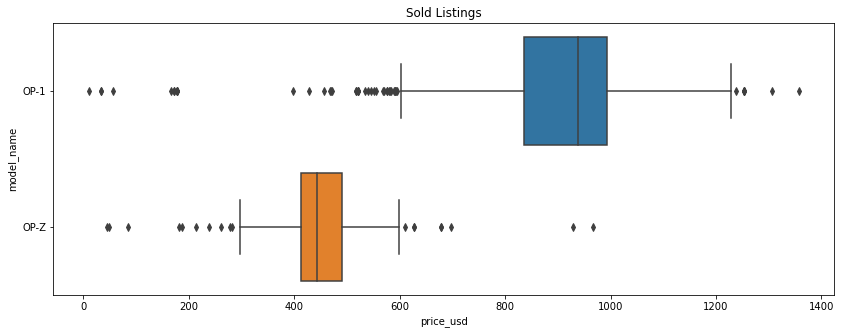

In [24]:
#Set figsize
plt.figure(figsize=(14,5))

#Inspect prices for Sold Models through Boxplot
sns.boxplot(x = 'price_usd', y = 'model_name', data = all_sold_listings)
plt.title('Sold Listings')
plt.show();

In [25]:
#Equation for retrieving outliers through Q1-1.5*IQR to spot listings that could be potential outliers
sold_quartiles_op1 = all_sold_listings[all_sold_listings['model_name'] == 'OP-1']['price_usd'].quantile(q = [0.25, 0.5, 0.75])
print('Outlier threshold OP-1 <', sold_quartiles_op1.iloc[0] - (1.5 * (sold_quartiles_op1.iloc[2] - sold_quartiles_op1.iloc[0])))

#Equation for retrieving outliers through Q1-1.5*IQR to spot listings that could be potential outliers
sold_quartiles_opz = all_sold_listings[all_sold_listings['model_name'] == 'OP-Z']['price_usd'].quantile(q = [0.25, 0.5, 0.75])
print('Outlier threshold OP-Z <', sold_quartiles_opz.iloc[0] - (1.5 * (sold_quartiles_opz.iloc[2] - sold_quartiles_opz.iloc[0])))

Outlier threshold OP-1 < 600.5
Outlier threshold OP-Z < 293.5


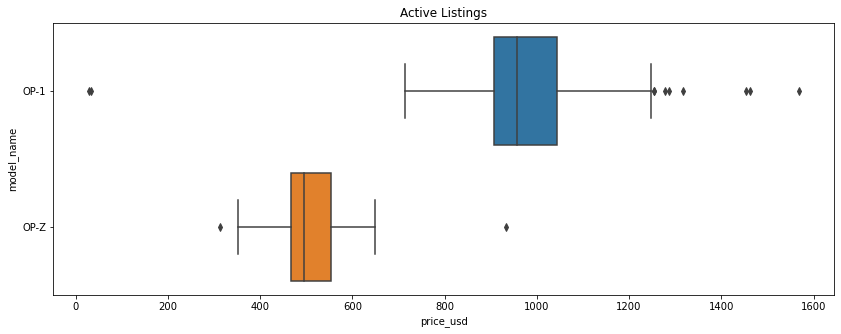

In [26]:
#Set figsize
plt.figure(figsize=(14,5))

#Inspect prices for Sold Models through Boxplot
sns.boxplot(x = 'price_usd', y = 'model_name', data = all_current_listings)
plt.title('Active Listings')
plt.show();

In [27]:
#Equation for spotting outliers through Q1-1.5*IQR to spot listings that are potential outliers
current_quartiles_op1 = all_current_listings[all_current_listings['model_name'] == 'OP-1']['price_usd'].quantile(q = [0.25, 0.5, 0.75])
print('Outlier threshold OP-1 <', current_quartiles_op1.iloc[0] - (1.5 * (current_quartiles_op1.iloc[2] - current_quartiles_op1.iloc[0])))

#Equation for spotting outliers through Q1-1.5*IQR to spot listings that are potential outliers
current_quartiles_opz = all_current_listings[all_current_listings['model_name'] == 'OP-Z']['price_usd'].quantile(q = [0.25, 0.5, 0.75])
print('Outlier threshold OP-Z <', current_quartiles_opz.iloc[0] - (1.5 * (current_quartiles_opz.iloc[2] - current_quartiles_opz.iloc[0])))

Outlier threshold OP-1 < 704.0
Outlier threshold OP-Z < 335.5


In [28]:
#Set display options to inspect full df's for outliers
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

In [29]:
#Inspect df and the descriptions for OP-1 Sold Listings to determine whether outliers are faulty data (accessories, spare parts etc) or actual listings that have just sold cheap
#Subset on listings <600 USD as these are spotted as potential outliers through above equation

all_sold_listings[(all_sold_listings['model_name'] == 'OP-1') & (all_sold_listings['price_usd'] <600)].sort_values('price_usd')

,listing,model_name,price_usd,marketplace,date_sold,country,Continent
140,decksaver teenage engineering op-1 dust cover,OP-1,10,ebay,2022-06-28,United Kingdom,Europe
52,kenton usb midi usb host mk3 iii for teenage engineering op-1 etc. top rare,OP-1,34,ebay,2022-08-11,Austria,Europe
57,decksaver ds-pc-op1 - designed to fit teenage engineering op1 protective cover-,OP-1,34,ebay,2022-08-08,United States,North America
47,teenage engineering op-1 portable synthesizer synthesiser accessories pack,OP-1,56,ebay,2022-08-14,United Kingdom,Europe
1044,brand new teenage engineering op-1 connector board replacement part audio jacks usb power op1 opz te,OP-1,167,reverb,NaT,United States,North America
1160,brand new teenage engineering op-1 connector board replacement part audio jacks usb power op1 opz,OP-1,172,reverb,NaT,United States,North America
1165,brand new teenage engineering op-1 connector board replacement part audio jacks usb power op1 opz te,OP-1,172,reverb,NaT,United States,North America
1164,brand new teenage engineering op-1 connector board replacement part audio jacks usb power op1 opz,OP-1,177,reverb,NaT,United States,North America
1163,brand new teenage engineering op-1 connector board replacement part audio jacks usb power op1 opz,OP-1,177,reverb,NaT,United States,North America
1162,brand new teenage engineering op-1 connector board replacement part audio jacks usb power op1 opz,OP-1,177,reverb,NaT,United States,North America


In [30]:
#Inspect df and the descriptions for OP-Z Sold Listings to determine whether outliers are faulty data (accessories, spare parts etc) or actual listings that have just sold cheap
#Subset on listings <286 USD as these are spotted as potential outliers through above equation

all_sold_listings[(all_sold_listings['model_name'] == 'OP-Z') & (all_sold_listings['price_usd'] <286)].sort_values('price_usd')

,listing,model_name,price_usd,marketplace,date_sold,country,Continent
177,kopfhörer teenage engineering m-1 faltbarer für op-z smartphones sound schwarz,OP-Z,44,ebay,2022-08-31,Germany,Europe
202,kopfhörer teenage engineering m-1 faltbarer für op-z smartphones unvollständig,OP-Z,48,ebay,2022-06-28,Germany,Europe
208,teenage engineering oplab module for op-z,OP-Z,85,ebay,2022-06-20,United Kingdom,Europe
195,teenage engineering op-z wireless bluetooth portable synthesizer sequencer,OP-Z,181,ebay,2022-07-16,United States,North America
205,teenage engineering op–z 16-track synthesizer with oplab module and carry case,OP-Z,188,ebay,2022-06-26,United Kingdom,Europe
189,teenage engineering op–z 16-track synthesizer and sequencer (with oplab module),OP-Z,213,ebay,2022-07-27,United Kingdom,Europe
183,teenage engineering op-z - mobiler synthesizer - unity game engine - ovp,OP-Z,238,ebay,2022-08-15,Germany,Europe
1271,"teenage engineering op-z 16-track synthesizer & sequencer, case, and 2 batteries",OP-Z,261,reverb,NaT,United States,North America
194,op-z von teenage engineering mit original usb-c ladekabel,OP-Z,279,ebay,2022-07-17,Germany,Europe
1355,teenage engineering op-z 16-track synthesizer & sequencer,OP-Z,282,reverb,NaT,United States,North America



### <span style="background-color:#FFD700">Through inspection of historical sales data and examining their listing descriptions we can see that fully working OP-1 models have sold as cheap as 197 USD and OP-Z for 181 USD, anything cheaper than that seem to be spare parts or accessories. Decision therefore to implement a price cap and remove data for OP-1 <200 USD and OP-Z <150 </span>




In [31]:
#Reset options for df
pd.reset_option('display.max_rows')

In [33]:

#Create filter for active listings
price_filter = (
    (all_current_listings['model_name'] == 'OP-Z') & (all_current_listings['price_usd'] <150)|(all_current_listings['model_name'] == 'OP-1') & (all_current_listings['price_usd'] < 200))

#Filter df
all_current_listings = all_current_listings.loc[~price_filter]

In [34]:
#Create filter for sold listings
price_filter = (
    (all_sold_listings['model_name'] == 'OP-Z') & (all_sold_listings['price_usd'] <150)|(all_sold_listings['model_name'] == 'OP-1') & (all_sold_listings['price_usd'] < 200))

#Filter df
all_sold_listings = all_sold_listings.loc[~price_filter]


# <span style="background-color:#FFD700">Export df's to Google Sheets via pygsheets</span>

In [36]:
#Authorize connection to Google API
cred_file = "/Users/tomlagerman 1/PythonNotebooks/Teenage Engineering Web Scraper/teenageengineering-web-scraper-ee3a7d3df350.json"
gc = pygsheets.authorize(service_file=cred_file)

#Open the Google Spreadsheet 
sh = gc.open('Teenage Engineering Web Scraper')


In [37]:
#Establish connection to correct sheet number
wks_ebay = sh[0]
wks_ebaysold = sh[1]
wks_reverb = sh[2]
wks_reverbsold = sh[3]
wks_all_current_listings = sh[4]
wks_all_sold_listings = sh[5]


#Clear all sheets to update and remove old data
wks_ebay.clear(start= 'A2', end='J5000')
wks_ebaysold.clear(start= 'A2', end='J5000')
wks_reverb.clear(start= 'A2', end='J5000')
wks_reverbsold.clear(start= 'A2', end='J5000')
wks_all_current_listings.clear(start= 'A2', end='J5000')
wks_all_sold_listings.clear(start= 'A2', end='J5000')


# Update all sheets with new data from df's
wks_ebay.set_dataframe(ebay_current_listings,(2,1), copy_head = False)
wks_ebaysold.set_dataframe(ebay_sold_listings,(2,1), copy_head = False)
wks_reverb.set_dataframe(reverb_current_listings,(2,1), copy_head = False)
wks_reverbsold.set_dataframe(reverb_sold_listings,(2,1), copy_head = False)
wks_all_current_listings.set_dataframe(all_current_listings,(2,1), copy_head = False)
wks_all_sold_listings.set_dataframe(all_sold_listings,(2,1), copy_head = False)




## <span style="background-color:#FFD700">Add new sheet of active listings per date to enable future tracking of listings over time</span>

In [38]:
#Establish connection
wks_active_listings_by_date = sh[6]

#Extract todays date
todays_date = str(date.today())

#Insert header titles
wks_active_listings_by_date.update_values(crange='A1:D1', values=[['Date','Active Listings', 'OP-1', 'OP-Z']])

#Count number of cells that already contain data as to not overwrite
number_of_cells = wks_active_listings_by_date.get_all_values(include_tailing_empty_rows=False, include_tailing_empty=False, returnas='matrix')

#Find the next empty row in sheet
non_empty_rows = []

for i in number_of_cells:
    if i != []:
        non_empty_rows.append(i)
                
count_non_empty_rows = len(non_empty_rows)

#Insert new Value in sheet
wks_active_listings_by_date.insert_rows(count_non_empty_rows, values=[todays_date, all_current_listings.shape[0],int(all_current_listings.value_counts('model_name')[0]), int(all_current_listings.value_counts('model_name')[1])], inherit=True)


## <span style="background-color:#FFD700">End of program</span>